## Analyzing single neuron activity

Thus far, you have largely been learning about how to analyze and interpret LFPs. In this section, we will introduce the analysis of single neuron (sometimes called single-unit) activity.

The predominant way in which a neuron communicates is through **action potentials**. These are rapid depolarizations across the neuronal cell membrane that culminate in a neuron releasing neurotransmitters that can do all sorts of things, like excite or inhibit action potentials in other neurons. Because action potentials are characterized by a large and fast change in membrane potential they can be recorded by microwires placed near the neuronal membrane, making them the most direct "biomarker" of neural activity. When we look at neuronal spiking during a behavioral task, we are often looking for increases in the rate of spiking related to behavioral variables. This is thought to imply a relationship between the stimulus and the neuron's spiking, and is called **rate coding**. 


Here, we are going to cover some of the basics of analyzing single neuron responses. It is worth noting that, single-unit recordings did not fall under the direct purview of the RAM project's data collections; as such, single-unit data loading and analyses don't follow the same standard protocol you've learned so far. Instead, we provide proprietary loading functions for the data (and do not focus too heavily on data processing). 

In [1]:
# Import some important libraries. You may have to install some of these.

import os 
import glob 
import math
import numpy as np 
import scipy.io as spio
from scipy.signal import fftconvolve
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

We will primarily be analyzing data from the Train task (which Josh covered in his talk). This is not a RAM task. As such, we have to first define some functions for loading the data, which is stored as event structures in matfiles. 

In [2]:
# Utility functions for loading data

def ev_loadmat(filename):
    '''
    This function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects. Incorporated from: https://stackoverflow.com/questions/7008608/scipy-io-loadmat-nested-structures-i-e-dictionaries
    '''

    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list

    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)

    return _check_keys(data)

def load_spikes(subjsess):
    """
    This function is used to load spiking data. We have to pull from a couple of disparate sources here.     
    :param subjsess: The subject identifier as well as the session number. Ex: 'R1219C_0' 
    :return: 
    fr: [events x neuron] numpy array of firing rate binned by time 
    spikeTimes: list of lists containing raw spiketimes (from beginning of recording, not beginning of task)
    spikeNames: array of channel names and cluster number for each putative single neuron
    spikeWaveforms: array of waveforms for putative single neurons
    """

    # define the location we want to look for the data
    ev_basedir = '/data3/events'
    task_dir = 'train'
    event_struct = subjsess + '_train_events.mat'

    subj_ev_path = str(os.path.join(ev_basedir, task_dir, event_struct))

    # Load the events, turn it into a dataframe
    events = ev_loadmat(subj_ev_path)['events']
    fr = np.array(events['fr'])

    spikeTimes = np.array(events['spikeData']['spikeTimes'])
    spikeNames = np.array(events['spikeData']['spikeNames'])

    return fr, spikeTimes, spikeNames

def load_events(subjsess):
    """
    Function for loading the pre-made train task events. These events basically parse the task into 100 ms bins.
    Note that they only explicitly cover times during which the subject is moving on the track. The CueOn/Off and
    FeedbackOn/Off times thus tell you when the hold and feedback periods occur for analyses of the data.
    :param subjsess: The subject identifier as well as the session number. Ex: 'R1219C_0'
    :return:
    events: pandas dataframe of task events
    """

    basedir = '/data3/events'
    subdir = 'train'
    event_struct = subjsess + '_train_events.mat'

    subj_ev_path = str(os.path.join(basedir, subdir, event_struct))

    # load the events, turn it into a dataframe
    events = ev_loadmat(subj_ev_path)['events']
    events_df = pd.DataFrame.from_records(events['events'])
    
    # clean up wall time/ position
    events_df['wall_time'] = events_df.apply(lambda x: x.wall_time if np.size(x.wall_time)==1 else np.nan, axis=1)
    events_df['wall_position'] = events_df.apply(lambda x: x.wall_position if np.size(x.wall_position)==1 else np.nan, axis=1)
    
    trialnums = events_df['trialNum'].max()

    # initialize the columns in the data frame for cue and feedback
    events_df["CueOnMs"] = np.nan
    events_df["CueOffMs"] = np.nan
    events_df["FeedbackOnMs"] = np.nan
    events_df["FeedbackOffMs"] = np.nan
    
    # Get the cue and feedback times and put them into the events
    try:
        CueOnMs = ev_loadmat(subj_ev_path)['CueOnUnixTime']
        CueOffMs = ev_loadmat(subj_ev_path)['CueOffUnixTime']
        FeedbackOnMs = ev_loadmat(subj_ev_path)['FeedbackOnUnixTime']
        FeedbackOffMs = ev_loadmat(subj_ev_path)['FeedbackOffUnixTime']
    except: 
        print('No Cue/Feedback Times for {}'.format(subjsess))
        return events_df

        
    # Because Cues and Feedback are only provided once per trial, let's only assign one value per all the events in that trial
    for trial in range(trialnums):
        events_df['CueOnMs'].loc[events_df['trialNum'] == trial + 1] = CueOnMs[trial]
        events_df['CueOffMs'].loc[events_df['trialNum'] == trial + 1] = CueOffMs[trial]
        events_df['FeedbackOnMs'].loc[events_df['trialNum'] == trial + 1] = FeedbackOnMs[trial]
        events_df['FeedbackOffMs'].loc[events_df['trialNum'] == trial + 1] = FeedbackOffMs[trial]
        
    return events_df

Let's pick a subject and session to analyze.

In [3]:
subjsess = 'R1219C_0'

Next, we can load the spiking data.

If you are curious how this data was extracted and processed in the first place, that's not covered here. However, we will (eventually) make an introduction to sorting and processing spiking data available as well. 

In [4]:
fr, spikeTimes, spikeNames = load_spikes(subjsess)

In [5]:
# How many neurons in this patient? 
num_neurons = spikeTimes.shape[-1]
print('We have {} neurons in this patient'.format(num_neurons))

We have 23 neurons in this patient


```fr``` is the firing rate of each neuron in a numpy array. Firing rate refers to the number of spikes divided by the amount of time you are looking at.

A key intuition here is that you can only measure "instantaneous" firing rate by **binning** the number of spikes into some window of time. In this case, they have been binned into 100 ms windows. So ```fr.shape[0]``` represents the number of non-overlapping 100 ms bins we have used to characterize the firing rate over time.

```spikeTimes``` is the actual time that each detected spike occurred, with time=0 being the moment the acquisition software was set to "record". Note that this is usually done before the task actually begins, so we (later) will need a way to relate these spike times to the times at which interesting things happen in the task. Spiking data is usually recorded at 30 KHz meaning we have HIGH temporal resolution.

```spikeNames``` tells you the microwire channel on which each neuron was recorded, as well as which cluster this neuron was on the channel. That's important, as an individual microwire can pick up more than one neuron. 


In [6]:
fr

array([[20,  0,  0, ..., 10,  0,  0],
       [10,  0,  0, ..., 20,  0,  0],
       [30,  0,  0, ..., 10, 10,  0],
       ...,
       [20,  0,  0, ..., 30,  0,  0],
       [ 0,  0, 10, ...,  0,  0,  0],
       [ 0, 10, 10, ..., 10, 10, 10]], dtype=uint8)

In [7]:
spikeNames

array(['NSX114_1', 'NSX114_2', 'NSX114_3', 'NSX115_1', 'NSX115_2',
       'NSX115_3', 'NSX116_1', 'NSX116_2', 'NSX117_1', 'NSX117_2',
       'NSX118_1', 'NSX118_2', 'NSX119_1', 'NSX120_1', 'NSX120_2',
       'NSX120_3', 'NSX122_1', 'NSX122_2', 'NSX124_1', 'NSX124_2',
       'NSX126_1', 'NSX126_2', 'NSX126_3'], dtype='<U8')

In [8]:
# It's important to check if spikeTimes are stored in seconds or ms. Usually they should be ms 
cell_ix = 0
spikeTimes[cell_ix][0:10]

[298.0,
 394.96666666666664,
 547.7,
 572.9666666666666,
 1179.9666666666665,
 1380.2,
 1567.7333333333333,
 1575.6,
 1788.0333333333333,
 1848.4333333333332]

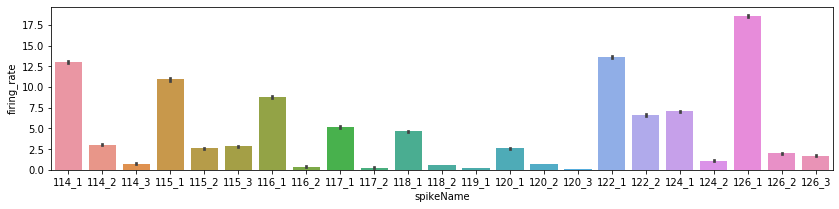

In [9]:
# Plot the mean firing rate for each neuron 
firing_rate_df = pd.DataFrame(fr, columns=spikeNames).melt(var_name='spikeName', value_name='firing_rate')
firing_rate_df['spikeName'] = firing_rate_df['spikeName'].apply(lambda x: x[3:])
f, ax = plt.subplots(1,1, figsize=[14,3])
sns.barplot(x='spikeName', y='firing_rate', data=firing_rate_df, ci=68)

This tells you how active, in general, each neuron was during the recording session. 

## -------------------------------------------------------------------------------------------------------------------------------
## (Optional)  Spiking statistics (first and second order) 
Before loading in behavior, let's look at some basic spike statistics. One way to assess spiking activity is to look at the time interval between each spike (aka the **interspike interval**). 

In [10]:
# # Compute ISI for Neuron 1 
# ISI = np.diff(np.array(spikeTimes[0]))
# sns.distplot(ISI)
# plt.xlabel('ISI (ms)')
# plt.ylabel('density')

We don't have to think about this too much for our analyses, but it's useful to understand that neuronal spiking is often conceptualized as a stochastic process, which is a fancy word for successive random events occuring in time. 

A Poisson process is a counting process used to model neuronal spiking because it treats each random event (spike) as independent. This is obviously not true in reality, but that's why it's a model. Let's measure the variability in the ISI distribution to see how it compares to an ideal Poisson process. A Poisson process produces distributions with 𝐶𝑉=1. A value of 𝐶𝑉>1 suggests that a spike train is less regular than if it were in fact generated by a Poisson process with the same firing rate. A value of 𝐶𝑉<1 suggests the spike train is more regular. 

In [11]:
# # Compute coefficient of variation
# CV = np.std(ISI)/np.mean(ISI)
# print(CV)

The CV does not capture potential variability on longer time scales especially if there's drift in the neuron's mean firing rate over time. A measure of spike time variability taking this long-term variability into account is the Fano factor, the ratio of the mean spike count and the variance the spike count within a time window. We will compute that a little later.

Another useful thing that ISI distribution can tell you is if the neuron you are looking at is a **bursty** neuron. By that, I mean a neuron that tends to fire a lot of action potentials in short bursts, rather than as isolated single spikes. As you can imagine, bursty neurons tend to violate Poisson assumptions and have ISI distributions that look a little more bimodal, with lots of spikes close together, and lots of bursts far apart. But that is a good segue into......

Now we will examine some second-order statistics, which allow us to look more carefully for regularities in spiking activity. 

First, we will attempt to compute the **autocorrelation** for a single neuron. 

Autocorrelations in timeseries data allow us to look at the correlation between the values of a timeseries at time x with values at other times (x−1), (x−2), etc. We shift our data by a lag-value (i.e. 10 ms) and compute a correlation, repeating this process for x amount of lags. This allows us to look for patterns or co-dependence between spikes. As a counter-example, white noise has a very flat autocorrelation function since it's random. 

In [12]:
# # First, let's define a utility function to compute correlations quickly! 

# @numba.jit(nopython=True)
# def pcorrelate(t, u, bins):
#     """Compute correlation of two arrays of discrete events (Point-process).

#     The input arrays need to be values of a point process, such as
#     photon arrival times or positions. The correlation is efficiently
#     computed on an arbitrary array of lag-bins. As an example, bins can be
#     uniformly spaced in log-space and span several orders of magnitudes.
#     (you can use :func:`make_loglags` to creat log-spaced bins).
#     This function implements the algorithm described in
#     `(Laurence 2006) <https://doi.org/10.1364/OL.31.000829>`__.

#     Arguments:
#         t (array): first array of "points" to correlate. The array needs
#             to be monothonically increasing.
#         u (array): second array of "points" to correlate. The array needs
#             to be monothonically increasing.
#         bins (array): bin edges for lags where correlation is computed.
#         normalize (bool): if True, normalize the correlation function
#             as typically done in FCS using :func:`pnormalize`. If False,
#             return the unnormalized correlation function.

#     Returns:
#         Array containing the correlation of `t` and `u`.
#         The size is `len(bins) - 1`.

#     See also:
#         :func:`make_loglags` to genetate log-spaced lag bins.
#     """
#     nbins = len(bins) - 1

#     # Array of counts (histogram)
#     counts = np.zeros(nbins, dtype=np.int64)

#     # For each bins, imin is the index of first `u` >= of each left bin edge
#     imin = np.zeros(nbins, dtype=np.int64)
#     # For each bins, imax is the index of first `u` >= of each right bin edge
#     imax = np.zeros(nbins, dtype=np.int64)

#     # For each ti, perform binning of (u - ti) and accumulate counts in Y
#     for ti in t:
#         for k, (tau_min, tau_max) in enumerate(zip(bins[:-1], bins[1:])):
#             if k == 0:
#                 j = imin[k]
#                 # We start by finding the index of the first `u` element
#                 # which is >= of the first bin edge `tau_min`
#                 while j < len(u):
#                     if u[j] - ti >= tau_min:
#                         break
#                     j += 1

#             imin[k] = j
#             if imax[k] > j:
#                 j = imax[k]
#             while j < len(u):
#                 if u[j] - ti >= tau_max:
#                     break
#                 j += 1
#             imax[k] = j
#             # Now j is the index of the first `u` element >= of
#             # the next bin left edge
#         counts += imax - imin
#     G = counts / np.diff(bins)
#     return G

In [13]:
# # Compute the autocorrelation for Neuron 1:

# bin_width = 10 # lag width in ms
# width = 1000  # correlation window in ms 

# st1 = np.array(spikeTimes[0]) # turn our spikeTime for Neuron 1 into an array

# n_lags = int(np.ceil(width / bin_width))  # Num. lags

# # Define the edges of the lag bins (including rightmost bin)
# lags = np.linspace(-width, width, 2 * n_lags, endpoint=True)

# corr_counts = pcorrelate(st1, st1, np.split(bins, 2)[1]) # NOTICE: we are computing a correlation between the signal and ITSELF. AUTOcorrelation!

# # Plot the outcome 
# ccf = np.ones(bins.shape[0] - 1)
# ccf[0:corr_counts.shape[0]] = np.flip(corr_counts)
# ccf[corr_counts.shape[0]] = corr_counts[0]
# ccf[corr_counts.shape[0] + 1:] = corr_counts
# plt.plot(bins, np.hstack((ccf[:1], ccf)))

We can see a very large autocorrelation at small time lags, which makes sense - the spiking data is most similar to itself when you don't shift it much. However, note that this falls off pretty quickly, so that spikes 500 ms away are far less correlated with eachother. 

Bonus: Think about LFP oscillations. Looking at an autocorrelation, can you think of a possible use here for looking at oscillations in the neural spiking? 

Similarly, we can compute the cross-correlation between two different neurons.

In [14]:
# # Compute the autocorrelation for Neuron 1:

# bin_width = 10 # lag width in ms
# width = 1000  # correlation window in ms 

# st1 = np.array(spikeTimes[0]) # turn our spikeTime for Neuron 1 into an array
# st2 = np.array(spikeTimes[1]) # turn our spikeTime for Neuron 2 into an array

# n_lags = int(np.ceil(width / bin_width))  # Num. lags

# # Define the edges of the lag bins (including rightmost bin)
# lags = np.linspace(-width, width, 2 * n_lags, endpoint=True)

# corr_counts = pcorrelate(st1, st2, np.split(bins, 2)[1]) # NOTICE: we are computing a correlation between the signal and ITSELF. AUTOcorrelation!

# # Plot the outcome 
# ccf = np.ones(bins.shape[0] - 1)
# ccf[0:corr_counts.shape[0]] = np.flip(corr_counts)
# ccf[corr_counts.shape[0]] = corr_counts[0]
# ccf[corr_counts.shape[0] + 1:] = corr_counts
# plt.plot(bins, np.hstack((ccf[:1], ccf)))

So it looks like Neuron 1 and Neuron 2 are fairly uncorrelated, despite being recorded on the same microwire. This is pretty good; it means we haven't accidentally split the same neuron into two different clusters!

## -------------------------------------------------------------------------------------------------------------------------------


## Single neuron activity during a task

In this section we will go over some simple single neuron analyses with respect to spatial position and memory. For reference, please see: https://www.nature.com/articles/s41593-019-0523-z

In [15]:
# Load the events
events = load_events(subjsess)

/home1/ryan.colyer/.conda/envs/environmentname/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [16]:
# Let's look at the structure of these events:
events.keys()

Index(['blockType', 'constant_speed', 'driveType', 'eegfile', 'eegoffset',
       'lfpfile', 'lfpmstime', 'lfpoffset', 'mstime', 'object',
       'object_position', 'position', 'response_mstime', 'response_position',
       'session', 'speed', 'subj', 'timesfile', 'timesoffset', 'trialNum',
       'wall_position', 'wall_time', 'CueOnMs', 'CueOffMs', 'FeedbackOnMs',
       'FeedbackOffMs'],
      dtype='object')

We won't get too much into the intricacies of the event design here vs. in the RAM tasks. Suffice to say they're different; we slice up every 100 ms of time that the person is moving through the track, rather than organizing by "events" like a word appearing onscreen. 

**The critical field in the event structure is the ```timesoffset``` field. The single-neuron recording system might be turned on before the task! And it's certainly turned off after the task stops logging. This field tells you the timepoints, relative to the spike times, that take place during the task**

Before we go any further, let's look at some spike trains. We didn't do this before because we didn't know when the task started and stopped - now we do, and can define a spike train using the spikes that happened during the task.

In [17]:
# Let's make a spike train of spikes during the task
cell_ix = 0
st = np.array(spikeTimes[cell_ix]) # turn into array so we can index it easily 

# find the indices corresponding to spikes during the task
st_to_keep = np.where(np.logical_and(st>=events.timesoffset.values[0], st<=events.timesoffset.values[-1]))[0].astype(int)

# we can baseline the spikes to the start of the task for generating a spike train 
st_baselined = st[st_to_keep] - events.timesoffset.values[0]

bin_width_st = 1 # this means our time resolution is 1 ms - sufficient for spike train generation and analysis 
st_sr = 1000 # This is our sampling rate 

ms_ix = np.arange(events.timesoffset.values[0], events.timesoffset.values[-1] + np.diff(events.timesoffset.values)[0], bin_width_st) - \
                       events.timesoffset.values[0]

# spike times are in ms, but are sampled at 30 KHz meaning  we have to round them to ms resolution
rounded_spike_times = np.round(st_baselined).astype(int)

# generate a spike train - a binary vector of 0's and 1's that is indexed by the spike times. Remember the bin width is 1 ms 

spiketrain = np.zeros(len(ms_ix))

# note we have to subtract 1 for pythonic indexing

spiketrain[rounded_spike_times - 1] = 1 

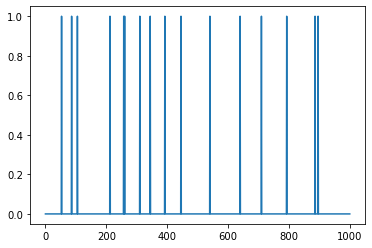

In [18]:
plt.plot(spiketrain[0:1000])

In [19]:
# Now we can compute the Fano Factor, which requires the spike train , during the task
print('This cell has a Fano factor of {}'.format(np.var(spiketrain) / np.mean(spiketrain)))

This cell has a Fano factor of 0.9879246999512845


One of the key reasons to define a spike train is so that we can smooth it to get a continuous **estimate** of spiking. We do this by convolving the spike train with a Gaussian kernel.

In [20]:
# Continuous firing rate parameters

bin_width_gauss = 10 # ms. set a wider bin width so we dont have a SUPER LONG vector! 

gauss_sr = int(1000/bin_width_gauss)

times_offset = events.timesoffset.values - events.timesoffset.values[0]

# make the bins 
binnedTime = np.arange(times_offset[0], times_offset[-1] + np.diff(times_offset)[0], bin_width_gauss)

# initialize the array
spkt = np.zeros(binnedTime.shape)

# Map the spike times to bins.
map_to_bins = np.digitize(st_baselined, binnedTime)
for i in map_to_bins:
    if i > 0:
        spkt[i - 1] += 1

In [21]:
# Define a window to filter in 
filt_window = np.arange(-1000, 1000, bin_width_gauss)

# factor to convert the convovled firing rate into Hz (spikes/second)
conv_rate_gaussian_fr = 1/(bin_width_gauss/1000) 

# Mess around with the std of the gaussian kernel - see how it changes the firing rate estimate 
smoothing_width = 75 # ms 

# Define the gaussian kernel
gaussian_kernel = 1. / np.sqrt(2 * math.pi * smoothing_width ** 2) * np.exp(
    -filt_window ** 2. / (2 * smoothing_width ** 2))

# Normalize the kernel so that the area sums to 1. 
gaussian_kernel =  gaussian_kernel / gaussian_kernel.sum()

# Do the smoothing! 
spkt_conv = conv_rate_gaussian_fr * fftconvolve(spkt, gaussian_kernel, 'same') 

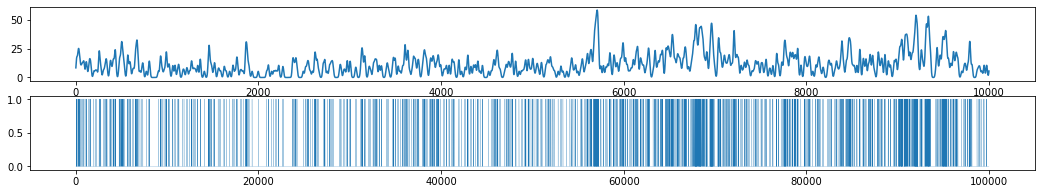

In [22]:
f, (gauss, train) = plt.subplots(2, 1, figsize=[18,3])

# Plot 100 s of data
time_win = 100
gauss.plot(spkt_conv[0:(time_win*gauss_sr)])
train.plot(spiketrain[0:(time_win*st_sr)], linewidth=0.2)

Having done all this table setting, let's look at how neural spiking changes in relation to task events. In general, the most useful tool for visualizing stimulus-related changes in the firing rate is the **peri-event rasters and histograms**. 

First, we have to do some data wrangling. The events here are not organized by trial/event, so we need to do that, then use our baselined spikes and the timesoffset field to parse the spiking the same way. 

In [23]:
# Does spiking change when the memory cue comes on the screen? 

# 1) Get the timing for the stimulus/event in question. Here, we want the time that the person makes their memory response.
cell_ix = 0 
all_response_times = [] 
for trialNum in events.trialNum.unique(): # Get the cue time for each individual trial
    first_ev_per_trial = events[events.trialNum==trialNum].iloc[0] # note that there is only one response per trial, but many events. That just means we log it many times. We just want the first one. 
    ResponseTime = first_ev_per_trial['response_mstime'] - events.mstime[0] # baseline to 0 
    all_response_times.append(ResponseTime)

# 2) You already baselined the spike tims for Neuron 1. If you didn't: 
st = np.array(spikeTimes[cell_ix]) # turn into array so we can index it easily 

# find the indices corresponding to spikes during the task
st_to_keep = np.where(np.logical_and(st>=events.timesoffset.values[0], st<=events.timesoffset.values[-1]))[0].astype(int)

# we can baseline the spikes to the start of the task for generating a spike train 
st_baselined = st[st_to_keep] - events.timesoffset.values[0]

# 3) Make a peri-event histogram + raster 

# define a time window (ms) to look around the stimulus:
time_window = [-500, 500]

# grab the spikes surrounding each stimulus 
spike_times_per_event = [] 
for response in all_response_times: 
    st_to_keep_event = np.where(np.logical_and(st_baselined>=response+time_window[0], 
                                               st_baselined<=response+time_window[1]))[0].astype(int)
    spike_times_per_event.append(st_baselined[st_to_keep_event] - response)


/home1/ryan.colyer/.conda/envs/environmentname/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater_equal
/home1/ryan.colyer/.conda/envs/environmentname/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less_equal


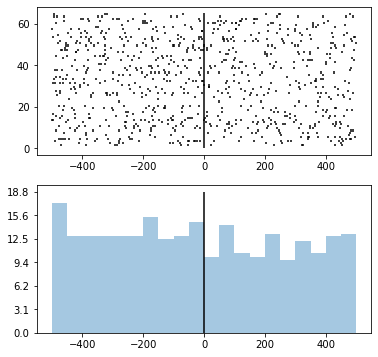

In [24]:
f, (raster, spike_hist) = plt.subplots(2, 1, figsize=[6,6])

# Plot the raster
trial = 1
for row in spike_times_per_event: 
    raster.vlines(row, trial, trial+1)
    trial+=1
raster.vlines(0, 0, trial)

# Compute the histogram in 50 ms bins
bin_width_ms = 50 
n_bins = int(1000/bin_width_ms)
H, b = np.histogram(np.hstack(spike_times_per_event), n_bins)
rate_factor = (bin_width_ms*events.trialNum.max()/1000)

sns.distplot(np.hstack(spike_times_per_event), bins=n_bins, kde=False, ax=spike_hist)
# Scale the y-axis so we are plotting firing rate in our bins, not just counts of spikes 
y_vals = spike_hist.get_yticks()
spike_hist.set_yticklabels(['{:3.1f}'.format(x/rate_factor) for x in y_vals])
spike_hist.vlines(0, 0, y_vals.max())

How do we do statistics for a PSTH? We won't cover that in specific detail here. But pay attention when you do problem #4 in the Assignments as the permutation statistics you do there will be very similar to what you might do for as PSTH. Broadly, you can either:

1) Identify specific times of increased firing: Generate surrogate PSTHs (i.e. 500 null observations per time bin). Compute a p-value for every bin. Do multiple comparisons correction across time bins. Are any time bins significantly higher/lower than surrogates? 

2) Compute mean firing rate pre and post and do a paired t-test. 


Now we want to do the spicy stuff: looking at neural activity as a function of position.

Up until this point, we have been binning spike counts by **time**. Now it's time to bin spike counts by **position**.

The easiest way to do this is to utilize pandas dataframe functionality, particularly the ```cut``` function to cut data into bins and the  ```groupby``` function to apply a function to these split data. 

In [25]:
n_spatial_bins=20
cell_ix = 0

data_df = pd.DataFrame(events['position'])
# Cut the environment into 20 bins and get the bin edges 
data_df['spatial_bin'], bin_edges = pd.cut(events.position, bins=n_spatial_bins, retbins=True, include_lowest=True, labels=np.arange(n_spatial_bins))
data_df['object_ID'] = events.object.apply(lambda x: x[0:-4])
data_df['object_bin'] = pd.cut(events.object_position, bins=bin_edges, retbins=False, include_lowest=True, labels=np.arange(n_spatial_bins))
data_df['fr'] = fr[:, cell_ix].astype(int)
data_df['trial'] = events.trialNum
data_df['subject'] = 1

In [26]:
data_df

,position,spatial_bin,object_ID,object_bin,fr,trial,subject
0,-33.970167,0,barrel,4,20,1,1
1,-33.835283,0,barrel,4,10,1,1
2,-33.584817,0,barrel,4,30,1,1
3,-33.217183,0,barrel,4,30,1,1
4,-32.736283,0,barrel,4,10,1,1
5,-32.138033,0,barrel,4,10,1,1
6,-31.424333,0,barrel,4,10,1,1
7,-30.594433,0,barrel,4,20,1,1
8,-29.650650,1,barrel,4,20,1,1
9,-28.588867,1,barrel,4,0,1,1


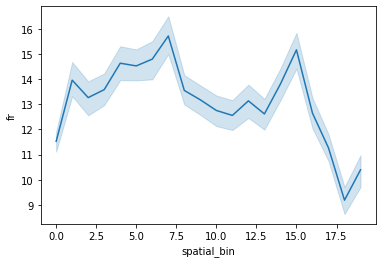

In [27]:
# Compute the actual spatially binned firing rate by averaging the firing rate over each bin 
spatially_binned_fr = data_df.groupby(by='spatial_bin').mean()
# Plot
sns.lineplot(x='spatial_bin', y='fr', data=data_df, ci=68) # Note that seaborn does the groupby().mean() itself 

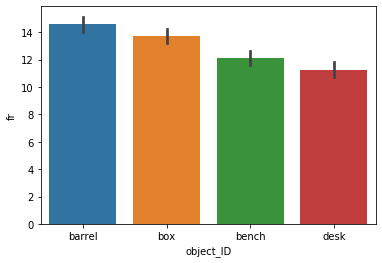

In [28]:
# Compute the firing rate for each different object cued for memory 
sns.barplot(x='object_ID', y='fr', data=data_df)

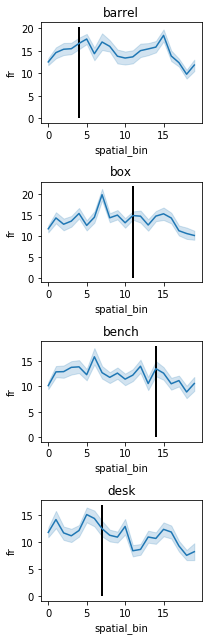

In [29]:
# Does spatial firing rate differ as a function of which object is cued for retrieval? 

diff_objects= data_df.object_ID.unique()
f, (obj1, obj2, obj3, obj4) = plt.subplots(4, 1, figsize=[3,9])
sns.lineplot(x='spatial_bin', y='fr', data=data_df[data_df.object_ID==diff_objects[0]], ci=68, ax=obj1)
sns.lineplot(x='spatial_bin', y='fr', data=data_df[data_df.object_ID==diff_objects[1]], ci=68, ax=obj2)
sns.lineplot(x='spatial_bin', y='fr', data=data_df[data_df.object_ID==diff_objects[2]], ci=68, ax=obj3)
sns.lineplot(x='spatial_bin', y='fr', data=data_df[data_df.object_ID==diff_objects[3]], ci=68, ax=obj4)

obj1.vlines(data_df[data_df.object_ID==diff_objects[0]].object_bin, 0, obj1.get_ylim()[-1])
obj2.vlines(data_df[data_df.object_ID==diff_objects[1]].object_bin, 0, obj2.get_ylim()[-1])
obj3.vlines(data_df[data_df.object_ID==diff_objects[2]].object_bin, 0, obj3.get_ylim()[-1])
obj4.vlines(data_df[data_df.object_ID==diff_objects[3]].object_bin, 0, obj4.get_ylim()[-1])

obj1.set_title(diff_objects[0])
obj2.set_title(diff_objects[1])
obj3.set_title(diff_objects[2])
obj4.set_title(diff_objects[3])

f.tight_layout()

# Statistical Analysis

Our next goal is to statistically determine if this neuron shows significant spatial tuning, significant object tuning, or an interaction of the two. Let's discuss each of these possibilites:

1) Significant spatial tuning: A neuron significantly increases it's firing in a particular location. We would call this a place cell. 

2) Significant object tuning: A neuron significantly increases it's firing when a particular object is cued for memory retrieval. 

3) Significant spatial x object: A neuron significantly increases it's firing in a particular location **as a function of the object cued for memory**. Put another way, the memory a person is cued to retrieve is affecting the spatial tuning of the neuron.

To assess these possibilities in an individual neuron, we are going to do a simple 2-way ANOVA. 

In [30]:
# Hypothesis testing: 

formula = 'fr~C(spatial_bin) + C(object_ID) + C(spatial_bin)*C(object_ID)'
model = ols(formula, data_df).fit()
aov_table = anova_lm(model, typ=2)
F_int = aov_table['F']['C(spatial_bin):C(object_ID)']
F_pos = aov_table['F']['C(spatial_bin)']
F_obj = aov_table['F']['C(object_ID)']
aov_table 

,sum_sq,df,F,PR(>F)
C(spatial_bin),1.877170e+04,19.0,6.779549,3.681931e-18
C(object_ID),1.320507e+04,3.0,30.204404,2.104132e-19
C(spatial_bin):C(object_ID),1.036921e+04,57.0,1.248308,9.945531e-02
Residual,1.103760e+06,7574.0,NaN,NaN


But wait - our data might violate normality assumptions for computing the significance of the test-statistic (F). 

As with the LFP data, we should compute our own null distributions from surrogate data to assess significance. See Assignment. 

In [31]:
# # If computing effects across subjects, must account for repeated trials: Use a repeated-measures ANOVA design 
# # pip install --upgrade pingouin
# import pingouin as pg
# aov = pg.rm_anova(dv='fr',
#                   within=['spatial_bin', 'object_ID'],
#                   subject='trial', data=data_df, detailed=)

## Assignment:

In this assignment, you will analyze human single neuron activity during a virtual-reality spatial memory task. In this task, subjects move down a linear track while encoding and retrieving the locations of objects along the track. You will plot neuronal spiking as a function of time and spatial position, and apply statistical methods for assessing significant changes in both domains. You will also measure the influence of memory cues and memory performance on spiking activity. 

1) Write a general function to plot the raster and histogram at a user defined time window and bin length (for the histogram). Use it to plot the rasters and histograms for CueOn, CueOff, FeedbackOn and FeedbackOff. This function should use baselined spike times and baselined event times/trial as input. Plot the output for one neuron. 

2) Write a similar function using the smoothed spiking activity instead of the PSTH. Keep in mind that the we computed the smoothed spiking activity at 100 Hz. Be sure to allow users to input width of smoothing kernel. You may want to write a separate function to smooth the firing rate, and call that within your function to plot the raster + smoothed firing rate. Plot the output for one neuron, with 3 different smoothing widths for your kernel. 

3) Calculate the mean firing rate and the error on every trial, and plot firing rate as a function of error. Hint: this is going to require that you again split the events into trials using the ```trialNum``` field. 
BONUS: Is there a statistical relationship between firing rate and memory performance? 

4) Do some shuffling to determine if the F-statistic from the spatial ANOVA is significant. Hint: use np.roll() to circularly shift data in a pandas dataframe: 
```df.reindex(index=np.roll(df.index, shift))```. If you see any neurons with a significant interaction in the ANOVA, make a plot of the spatial firing rate split by object. If you see any neurons that do not have a significant interaction but do have a significant main effect of location, make a plot of the spatial firing rate over all trials. 
